### checking the evolution of road stations over time

In [1]:
import os
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
import datetime

# File path and column names
DPATH = "~/sync_laptops/NOTES/RoadWeather/"
FILE = "vejvejr_update_202407.csv"
cols = ["SID", "c2", "c3", "SID_again", "name", "lon", "lat", "creation_date"] + [f"c{i+8}" for i in range(15)]

# Read the CSV file
all_stations = pd.read_csv(os.path.join(DPATH, FILE), encoding='cp865', header=None, names=cols)

# Convert creation_date to datetime
all_stations['creation_date'] = pd.to_datetime(all_stations['creation_date'].astype(str), format='%Y%m%d%H%M')

def get_stations_by_year(year):
    return all_stations[all_stations['creation_date'].dt.year <= year]

def create_map_with_stations(year):
    stations = get_stations_by_year(year)
    
    # Create a base map centered on Denmark
    m = folium.Map(location=[56.26392, 9.501785], zoom_start=7)
    
    # Create a colormap based on creation years
    min_year = 1980
    max_year = 2024
    colormap = cm.LinearColormap(colors=['blue', 'green', 'yellow', 'red'], 
                                 vmin=min_year, 
                                 vmax=max_year)
    
    # Add markers for each station
    marker_cluster = MarkerCluster().add_to(m)
    for idx, row in stations.iterrows():
        creation_year = row['creation_date'].year
        color = colormap(creation_year)
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=8,  # Increased size
            popup=f"SID: {row['SID']}<br>Created: {row['creation_date'].date()}",
            color=color,
            fill=True,
            fillColor=color,
            fillOpacity=1.0  # Make circles solid
        ).add_to(marker_cluster)
    
    # Add the colormap to the map
    colormap.add_to(m)
    colormap.caption = 'Station Creation Year'
    
    # Modify the colormap's tick labels to show years
    colormap.tick_labels = {
        i: str(year) for i, year in enumerate(range(min_year, max_year + 1, 5))
    }
    
    return m

# Example usage
map_2024 = create_map_with_stations(2024)
map_2024.save("stations_map_2024.html")

print("Map has been saved as 'stations_map_2024.html'. Open this file in a web browser to view the interactive map.")

# To create maps for multiple years
for year in range(1980, 2025, 1):  # Create a map every 5 years
    map_year = create_map_with_stations(year)
    map_year.save(f"stations_map_{year}.html")
    print(f"Map for year {year} has been saved.")

Map has been saved as 'stations_map_2024.html'. Open this file in a web browser to view the interactive map.
Map for year 1980 has been saved.
Map for year 1981 has been saved.
Map for year 1982 has been saved.
Map for year 1983 has been saved.
Map for year 1984 has been saved.
Map for year 1985 has been saved.
Map for year 1986 has been saved.
Map for year 1987 has been saved.
Map for year 1988 has been saved.
Map for year 1989 has been saved.
Map for year 1990 has been saved.
Map for year 1991 has been saved.
Map for year 1992 has been saved.
Map for year 1993 has been saved.
Map for year 1994 has been saved.
Map for year 1995 has been saved.
Map for year 1996 has been saved.
Map for year 1997 has been saved.
Map for year 1998 has been saved.
Map for year 1999 has been saved.
Map for year 2000 has been saved.
Map for year 2001 has been saved.
Map for year 2002 has been saved.
Map for year 2003 has been saved.
Map for year 2004 has been saved.
Map for year 2005 has been saved.
Map for

### The following part only works for domains up to less than 12 tiles. See the script download_tiles.py for other ways to download
### Also the data path might not be correct. DO NOT save the file as it can be 500 MB large


In [32]:
get_dem = False #jumping over this for the moment. Getting the dem file outside of the notebook

if get_dem:

    import elevation
    import os
    from osgeo import gdal
    
    # Define the bounding box for Denmark
    
    #box: minlon,minlat,maxlon,maxlat
    bbox = (7.0, 54.5, 13.0, 58.0)  # (min_lon, min_lat, max_lon, max_lat)
    #bbox = (7.0,54.5,17,58.0)
    
    # Split the bounding box into smaller regions
    def split_bbox(bbox, rows, cols):
        min_lon, min_lat, max_lon, max_lat = bbox
        lon_step = (max_lon - min_lon) / cols
        lat_step = (max_lat - min_lat) / rows
        
        bboxes = []
        for i in range(rows):
            for j in range(cols):
                bboxes.append((
                    min_lon + j * lon_step,
                    min_lat + i * lat_step,
                    min_lon + (j + 1) * lon_step,
                    min_lat + (i + 1) * lat_step
                ))
        return bboxes
    
    # Example: 2 rows and 3 columns
    sub_bboxes = split_bbox(bbox, 2, 3)
    
    # Directory to save the individual DEM files
    output_dir = "/home/cap/denmark_dem_tiles"
    os.makedirs(output_dir, exist_ok=True)
    
    output_file = "denmark_dem_merged.tif"
    
    if not os.path.isfile(output_file):
    
    # Download each sub-region
        tile_files = []
        for idx, sub_bbox in enumerate(sub_bboxes):
            output_file = os.path.join(output_dir, f"tile_{idx}.tif")
            elevation.clip(bounds=sub_bbox, output=output_file)
            tile_files.append(output_file)
            print(f"Downloaded: {output_file}")
    
        # Merge the tiles into a single file (optional)
        merged_output_file = output_file
    
        vrt_options = gdal.BuildVRTOptions(resampleAlg='cubic', addAlpha=True)
        vrt = gdal.BuildVRT("merged.vrt", tile_files, options=vrt_options)
        gdal.Translate(merged_output_file, vrt)
        vrt = None  # Close the VRT file
    
        print(f"Merged DEM file saved to: {merged_output_file}")
    else:
        print(f"{output_file} already created")


In [6]:
# Not using this for the moment. Getting shp file from data/DK

import requests

def get_denmark_boundary():
    # URL for the Natural Earth low resolution countries dataset
    #https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
    #url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip"

    # Download the zip file
    #response = requests.get(url)
    
    # Extract the shapefile from the zip
    #with ZipFile(BytesIO(response.content)) as zip_file:
    #ifile = "/home/cap/Downloads/ne_110m_admoin_0_countries.zip"
    ifile = "/home/cap/Downloads/ne_110m_admin_0_countries.zip"
    #with "/home/cap/Downloads/ne_110m_admoin_0_countries.zip" as zip_file
    
    #with  ZipFile(BytesIO(ifile)) as zip_file:
    # Find the .shp file in the zip
    #    shp_file = [f for f in zip_file.namelist() if f.endswith('.shp')][0]
    #print(shp_file)    
    # Read the shapefile directly from the zip
    shp_file = "/home/cap/Downloads/countries/ne_110m_admin_0_countries.shp"
    #with open(shp_file) as shp:
    world = gpd.read_file(shp_file)
    #print(world)
    # Filter to get only Denmark
    denmark = world[world['NAME'] == 'Denmark']
    
    return denmark

6.9998611111111115
12.999861111111112
54.50013888888889
58.00013888888889


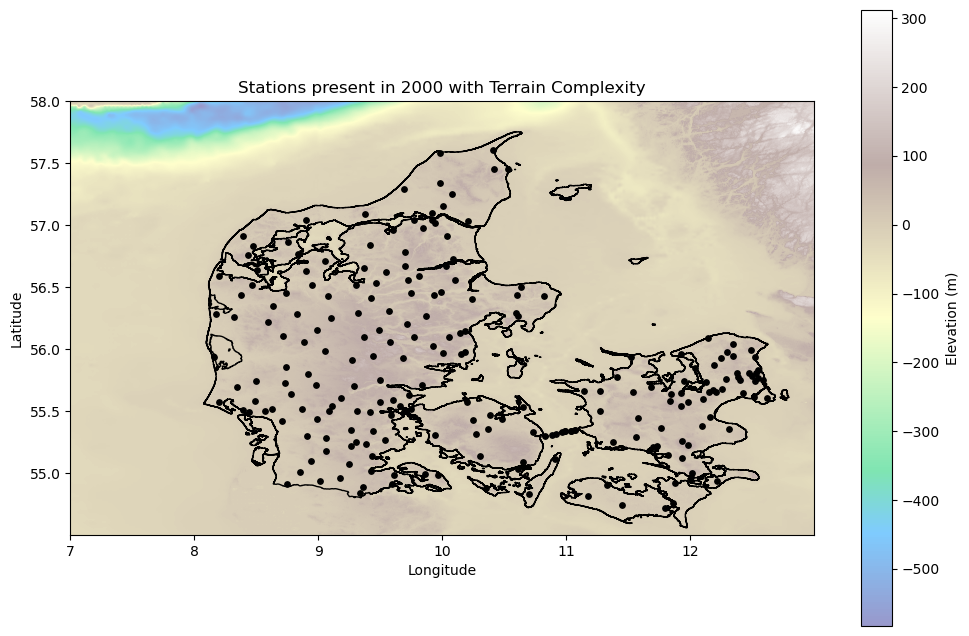

In [29]:


import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import datetime
import rasterio
import numpy as np
import requests
from io import BytesIO
from zipfile import ZipFile

def plot_stations_with_terrain(year, dem_path):
    stations = get_stations_by_year(year)
    
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the terrain
    with rasterio.open(dem_path) as src:
        elevation = src.read(1)  # Read the first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        print(src.bounds.left)
        print(src.bounds.right)
        print(src.bounds.bottom)
        print(src.bounds.top)
        #extent = [7,13,54,58]
        im = ax.imshow(elevation, extent=extent, cmap='terrain', alpha=0.5)
    
    # Add a colorbar for elevation
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Elevation (m)')
    denmark = gpd.read_file("./data/DK/DNK_adm0.shp")
    # Plot Denmark's boundaries
    #denmark = gpd.read_file(gpd.datasets.get_path('denmark'))
    #denmark = gpd.read_file("shapefiles/dk_10km.shp")
    #denmark = get_denmark_boundary()

    plot_dk = denmark.plot(ax=ax, color='none', edgecolor='black')
    plot_dk.set_xlim(extent[0],extent[1])
    plot_dk.set_ylim(extent[2],extent[3])
    # Plot the stations
    red_stations = stations[stations["lon"] < 13]
    ax.scatter(stations['lon'], stations['lat'], color="black", s=15)
    
    # Set the title and labels
    ax.set_title(f"Stations present in {year} with Terrain Complexity")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    # Show the plot
    plt.show()

# Example usage
dem_path = "denmark_dem_merged.tif"
dem_path = "./denmark_dem_tiles/denmark_dem_merged.tif"
dem_path = "./denmark_dem_tiles/denmark_extended.tif"
plot_stations_with_terrain(2000, dem_path)

6.9998611111111115
12.999861111111112
54.50013888888889
58.00013888888889


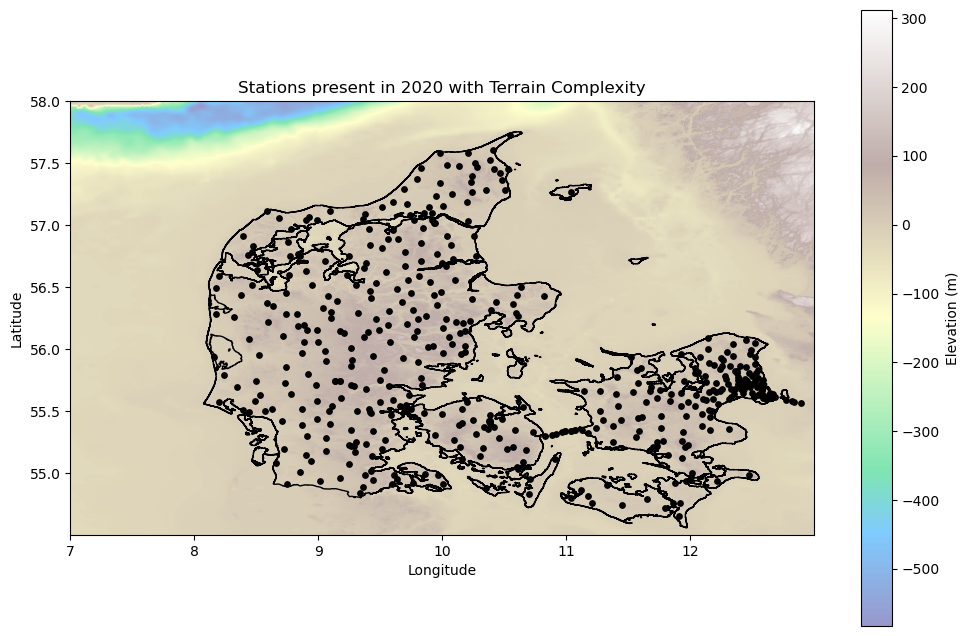

In [30]:
plot_stations_with_terrain(2020, dem_path)

6.9998611111111115
12.999861111111112
54.50013888888889
58.00013888888889


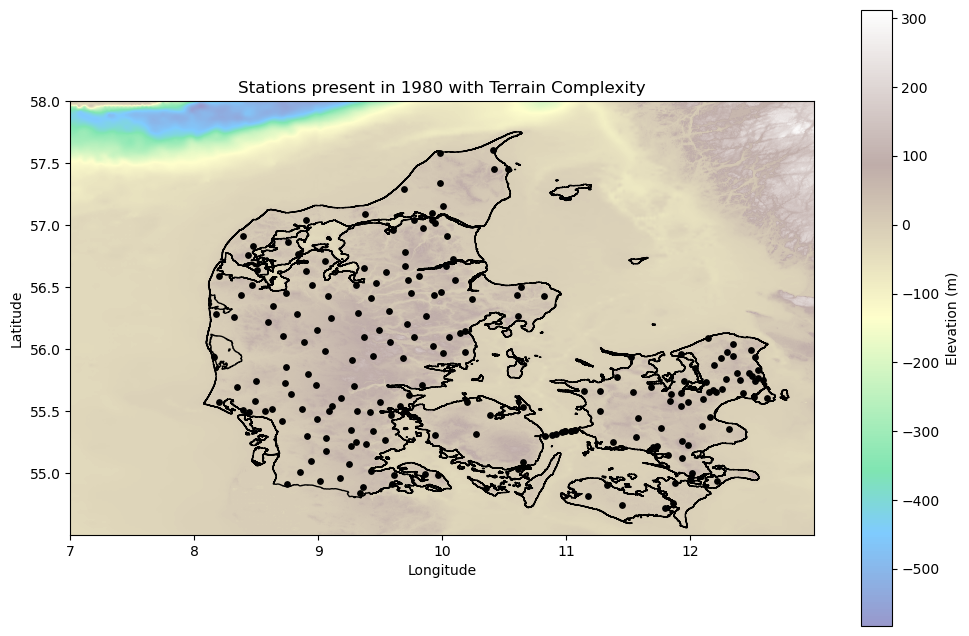

In [31]:
plot_stations_with_terrain(1980, dem_path)